0.023799785336203427 arcsec
DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 


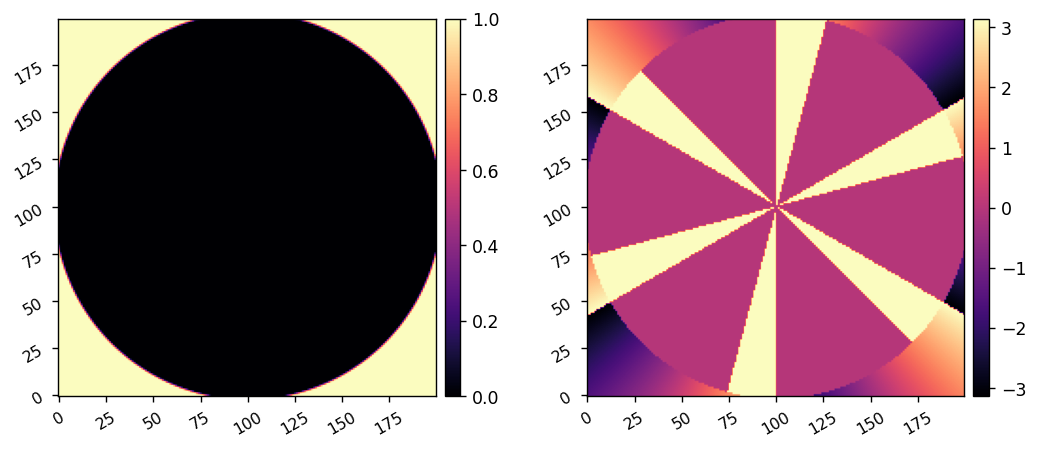

In [3]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import coro, coro2, agpm
import misc_funs as misc
reload(coro)
reload(coro2)
reload(agpm)
reload(misc)

diam = 6.5*u.m
wavelength_c = 750e-9*u.m
as_per_lamd = (wavelength_c/diam *u.radian).to(u.arcsec)
print(as_per_lamd)

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=80*u.um)
wave = poppy.FresnelWavefront(wavelength=wavelength_c, beam_radius=50*u.um, npix=256, oversample=1)
vvc_phasor = vortex.get_phasor(wave)
misc.imshow2(np.abs(vvc_phasor), np.angle(vvc_phasor),
             npix=200)

0.0011899892668101714 arcsec


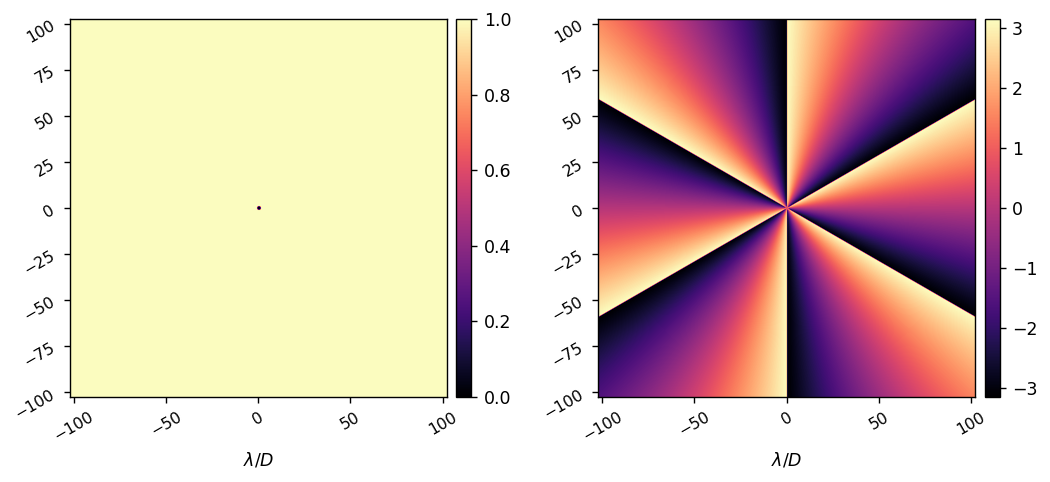

Saved data to:  fpm_0.05lamD_amp.fits
Saved data to:  fpm_0.05lamD_opd.fits
DEBUG:poppy:Trans: fpm_0.05lamD_amp.fits
DEBUG:poppy:OPD: fpm_0.05lamD_opd.fits
INFO:poppy:FPM: Loaded amplitude transmission from fpm_0.05lamD_amp.fits
INFO:poppy:FPM: Loaded OPD from fpm_0.05lamD_opd.fits
DEBUG:poppy:FixedSamplingImagePlaneElement FPM initialized:centering style ADJUSTABLE, central wavelength for operation 7.5e-07 m, entrance pupil diameter of system 6.5 m, pixelscale of 0.001189989266810171 arcsec/pix.


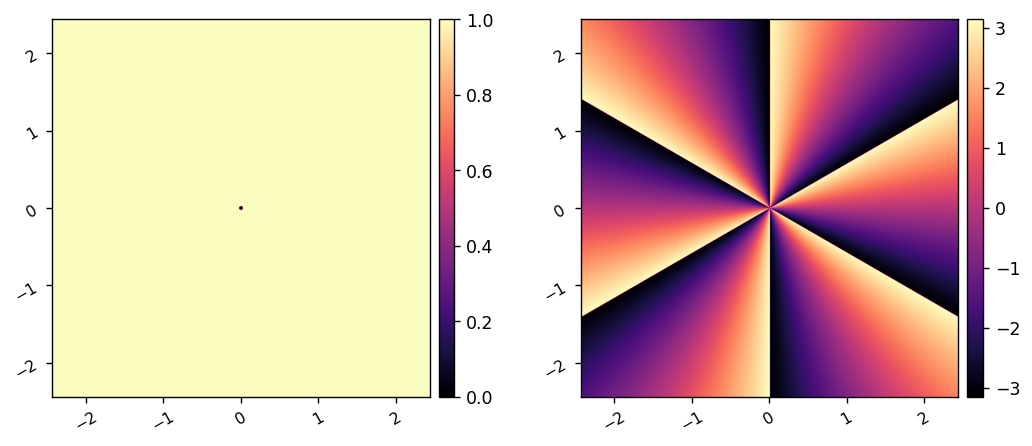

In [6]:
n = 4096
pxscl = 0.05
pxscl_as = pxscl*as_per_lamd
print(pxscl_as)

xfp = pxscl*(np.linspace(-n//2, n//2-1, n) + 1/2)
fpx, fpy = np.meshgrid(xfp,xfp)
rfp = np.sqrt(fpx**2 + fpy**2)
phase = np.arctan2(fpy,fpx)

charge = 6

fpm_amp = np.float64((rfp>1))
fpm_opd = charge * phase * wavelength_c.value/ (2 * np.pi)
fpm = fpm_amp * np.exp(1j* 2*np.pi/wavelength_c.value *fpm_opd)

misc.imshow2(abs(fpm), np.angle(fpm),
             pxscl1=pxscl, pxscl2=pxscl, xlabel='$\lambda/D$')

header={'WAVELENC':750e-9, 'PUPLDIAM':6.5, 'PIXSCLLD':0.05, 'PIXELSCL':pxscl_as.value}
misc.save_fits('fpm_0.05lamD_amp.fits', data=fpm_amp, header=header)
misc.save_fits('fpm_0.05lamD_opd.fits', data=fpm_opd, header=header)

FPM = poppy.FixedSamplingImagePlaneElement('FPM', 
                                           transmission='fpm_0.05lamD_amp.fits', 
                                           opd='fpm_0.05lamD_opd.fits', opdunits='meters',
                                          )
misc.imshow2(FPM.amplitude, np.angle(np.exp(1j*FPM.opd*2*np.pi/wavelength_c.value)), 
             pxscl1=FPM.pixelscale, pxscl2=FPM.pixelscale,)


In [8]:
reload(coro)
poppy_log.disabled = True

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=80*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

c = coro.CORO(dm_inf='inf.fits',
              npix=256,
              oversample=8,
              LYOT=lyot_stop,
             )

# c = coro.CORO(dm_inf='inf.fits',
#               npix=128,
#               oversample=16,
#               LYOT=lyot_stop,
#              )

Propagating wavelength 750.000 nm.
PSF calculated in 0.857s


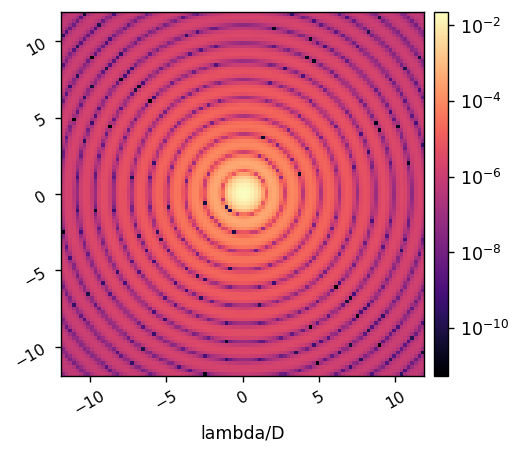

Propagating wavelength 750.000 nm.
PSF calculated in 0.463s


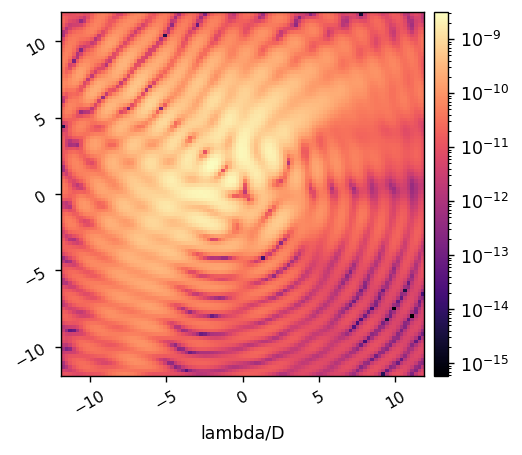

Propagating wavelength 750.000 nm.
PSF calculated in 2.530s


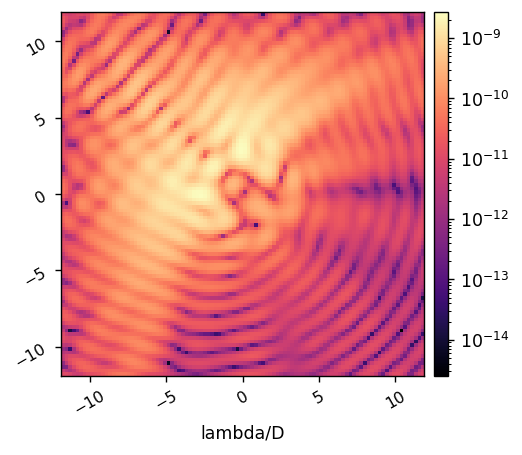

In [9]:
poppy_log.disabled = True
c.FPM = None
psf = c.calc_psf(quiet=False)
misc.imshow1(abs(psf)**2, lognorm=True, pxscl=c.psf_pixelscale_lamD)

c.FPM = vortex
psf = c.calc_psf(quiet=False)
misc.imshow1(abs(psf)**2, lognorm=True, pxscl=c.psf_pixelscale_lamD)

c.FPM = FPM
psf = c.calc_psf(quiet=False)
misc.imshow1(abs(psf)**2, lognorm=True, pxscl=c.psf_pixelscale_lamD)

In [10]:
poppy_log.disabled = True
c.FPM = vortex
vvc_wf_1 = c.calc_wfs()[c.fpm_index]

c.FPM = FPM
vvc_wf_2 = c.calc_wfs()[c.fpm_index]

Propagating wavelength 750.000 nm.
PSF calculated in 0.730s
Propagating wavelength 750.000 nm.
PSF calculated in 1.841s


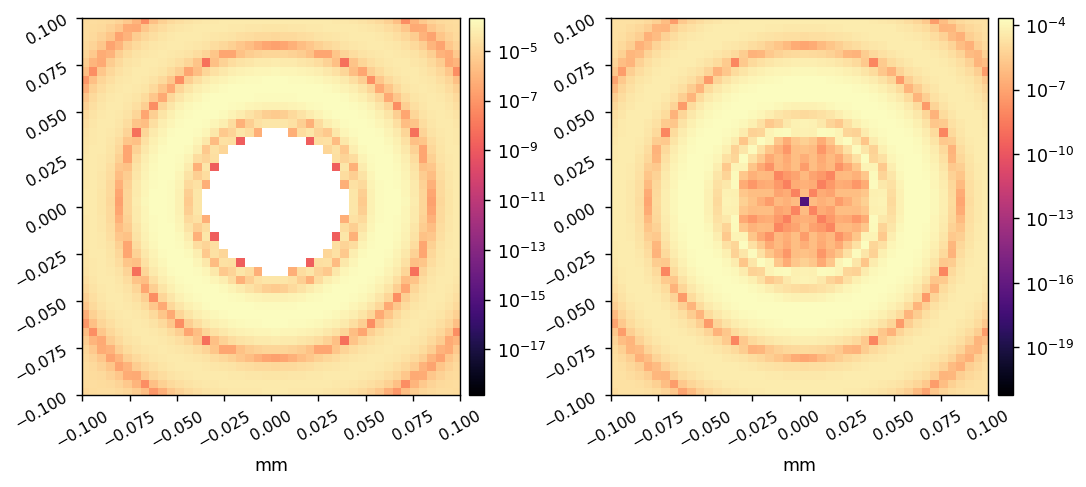

In [23]:
reload(misc)
fp_lim = 1/10
ext = [-fp_lim, fp_lim, -fp_lim, 0.1]
misc.imshow2(vvc_wf_1.intensity, vvc_wf_2.intensity, 
             xlabel='mm',
             axlims=ext,
             pxscl1=vvc_wf_1.pixelscale.to(u.mm/u.pix), 
             pxscl2=vvc_wf_2.pixelscale.to(u.mm/u.pix),
             lognorm1=True, lognorm2=True)

In [18]:
wfs = c.calc_wfs()

Propagating wavelength 750.000 nm.
PSF calculated in 2.109s


In [21]:
wfs

3.9843749999999996e-05 m / pix


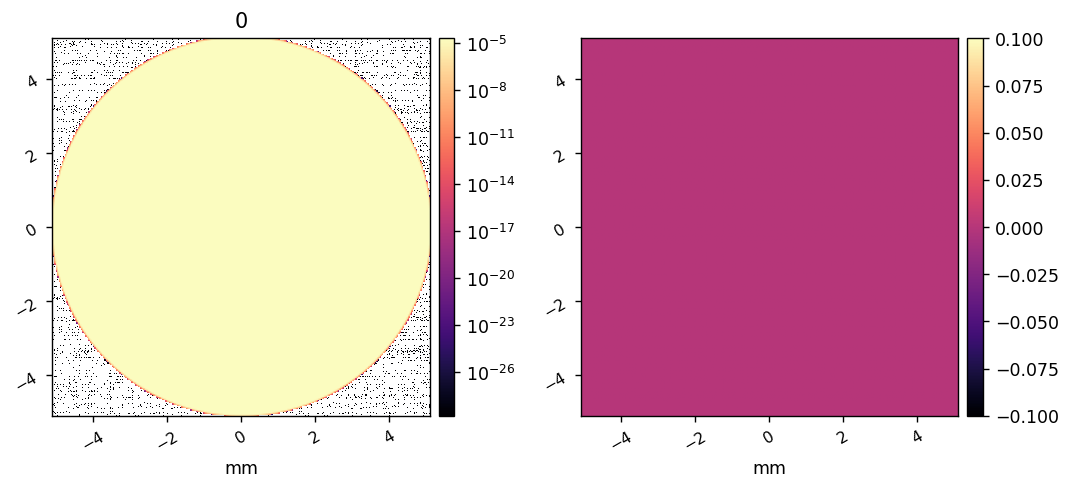

3.9843749999999996e-05 m / pix


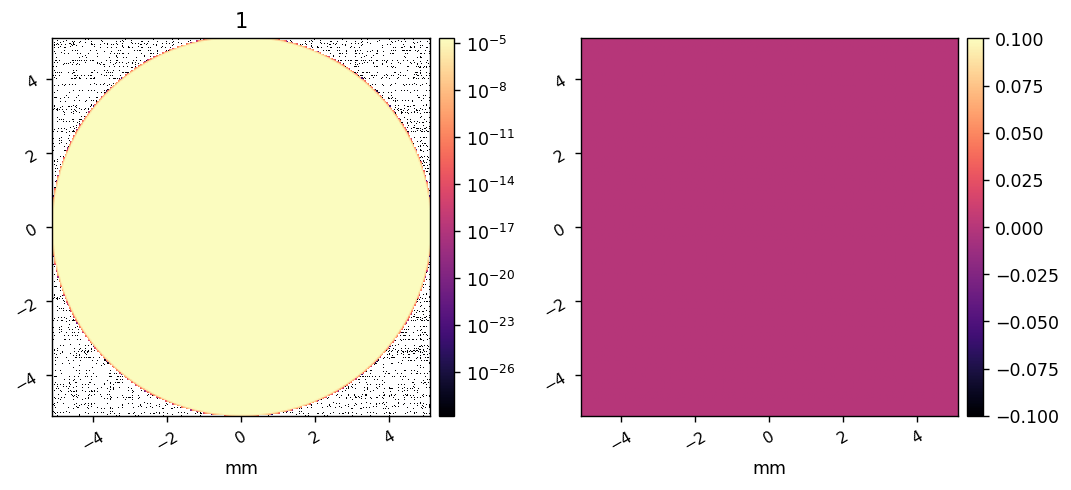

3.9843749999999996e-05 m / pix


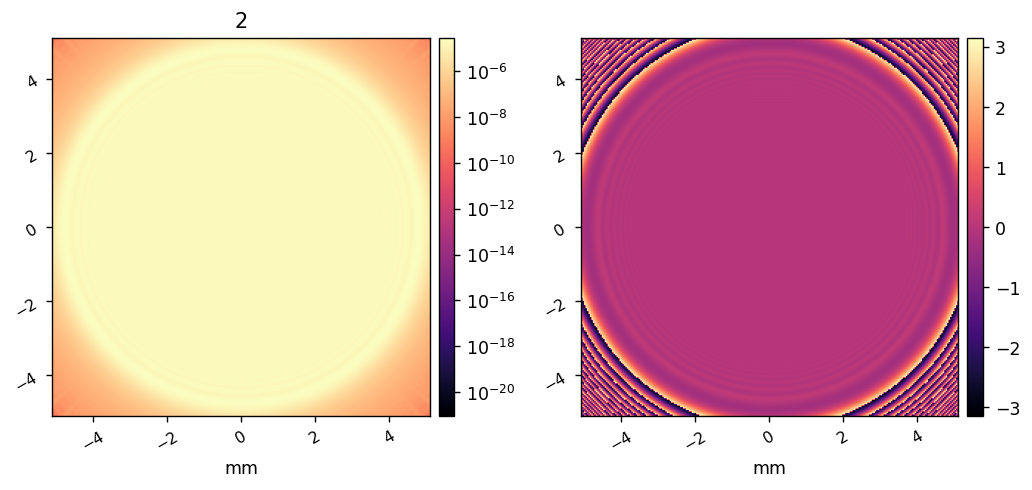

3.9843749999999996e-05 m / pix


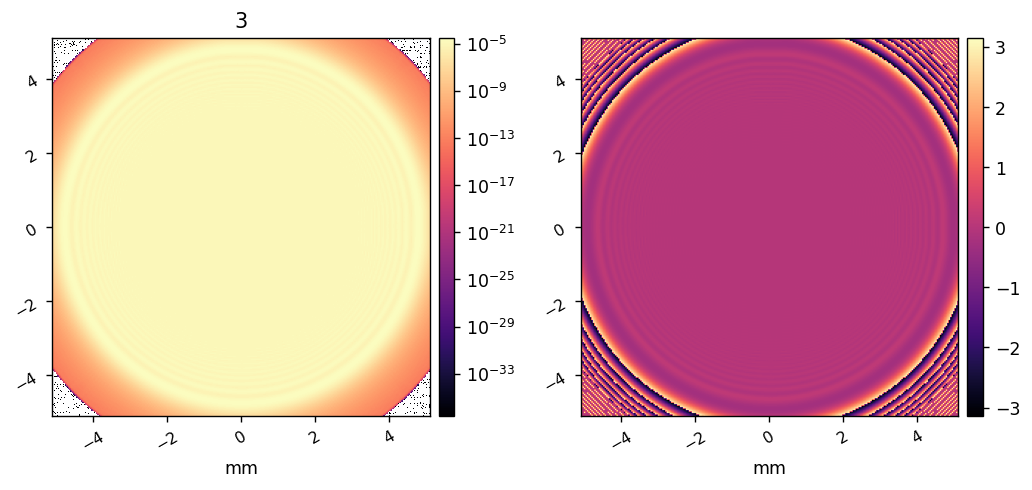

1.8382290997243229e-06 m / pix


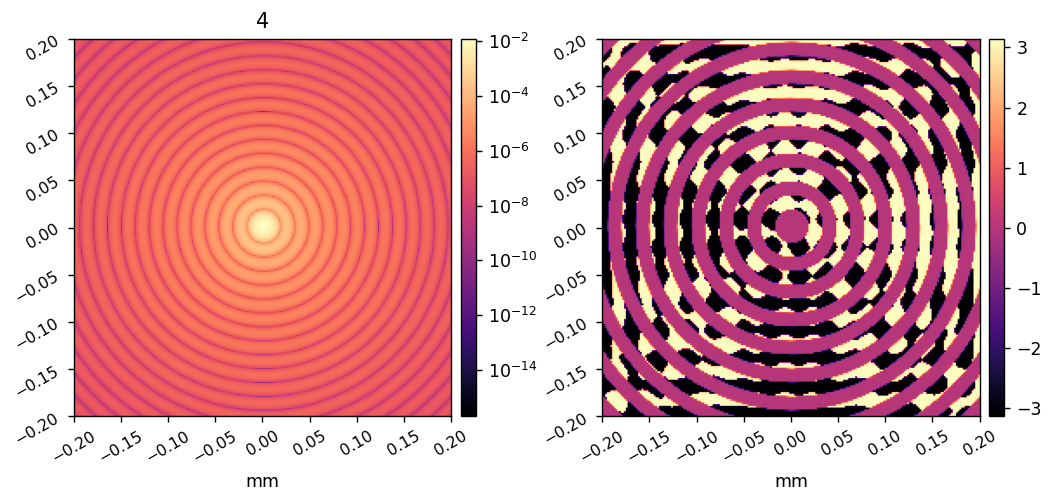

3.98440185278555e-05 m / pix


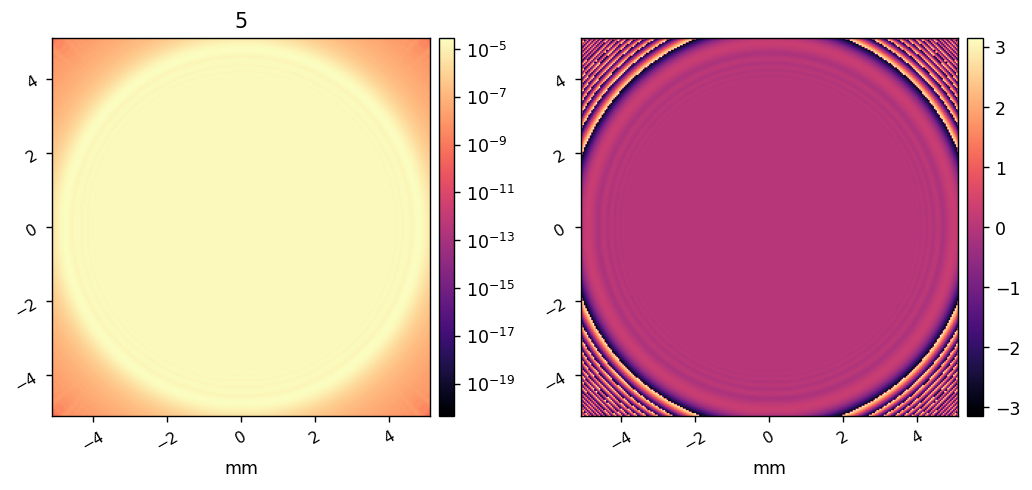

3.98440185278555e-05 m / pix


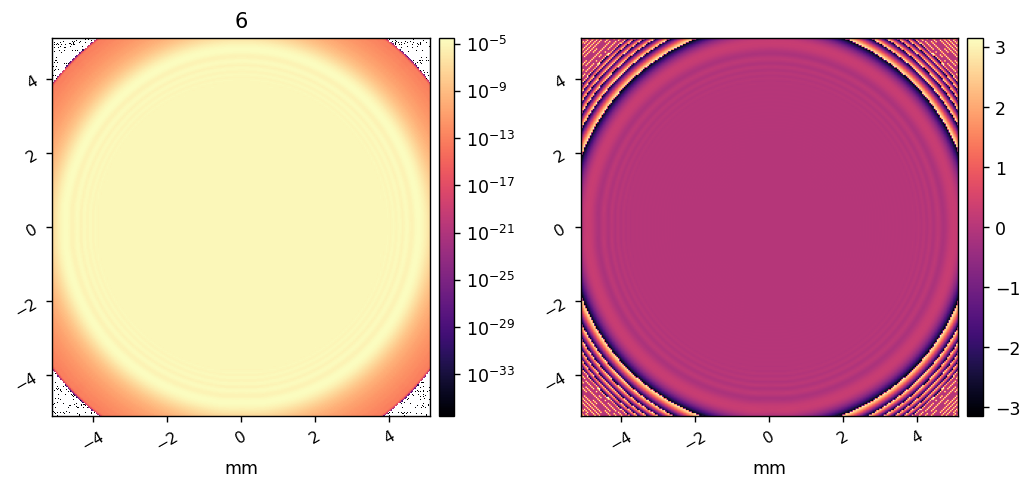

3.98440185278555e-05 m / pix


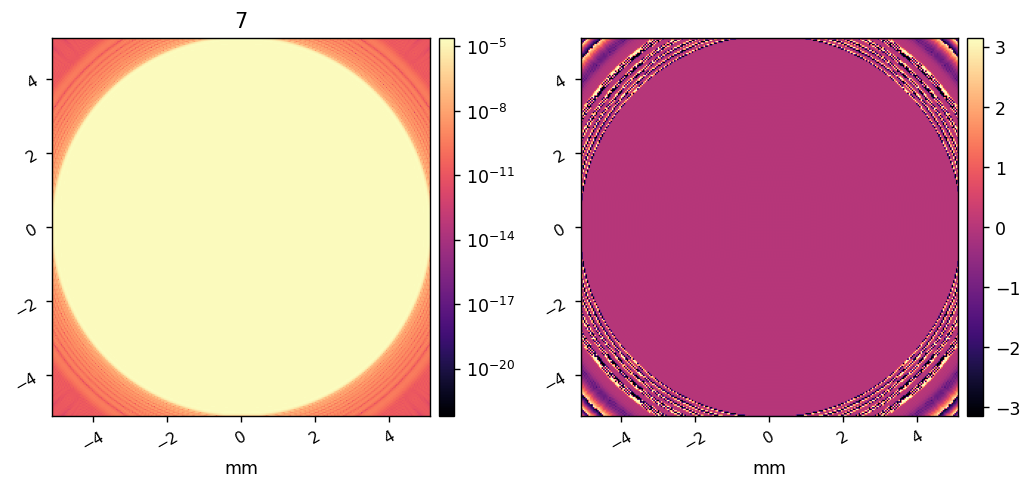

3.98440185278555e-05 m / pix


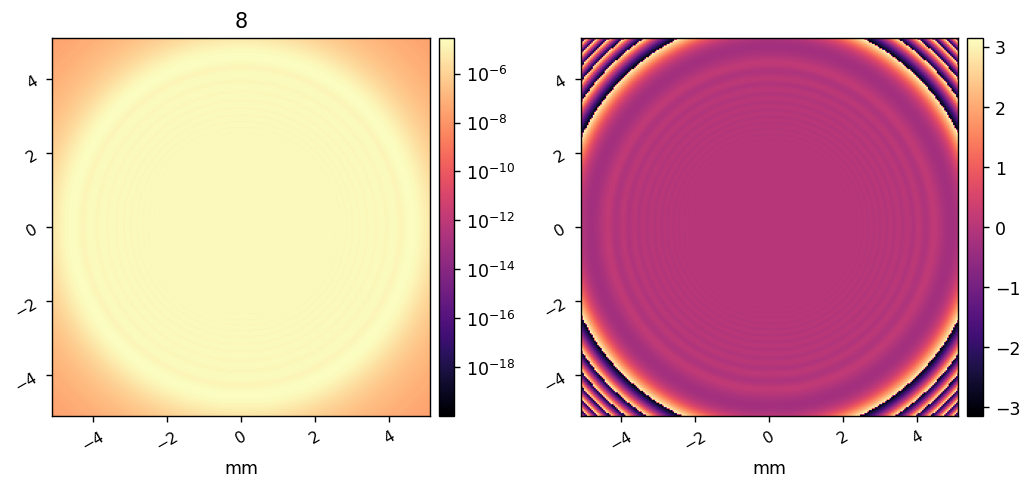

3.98440185278555e-05 m / pix


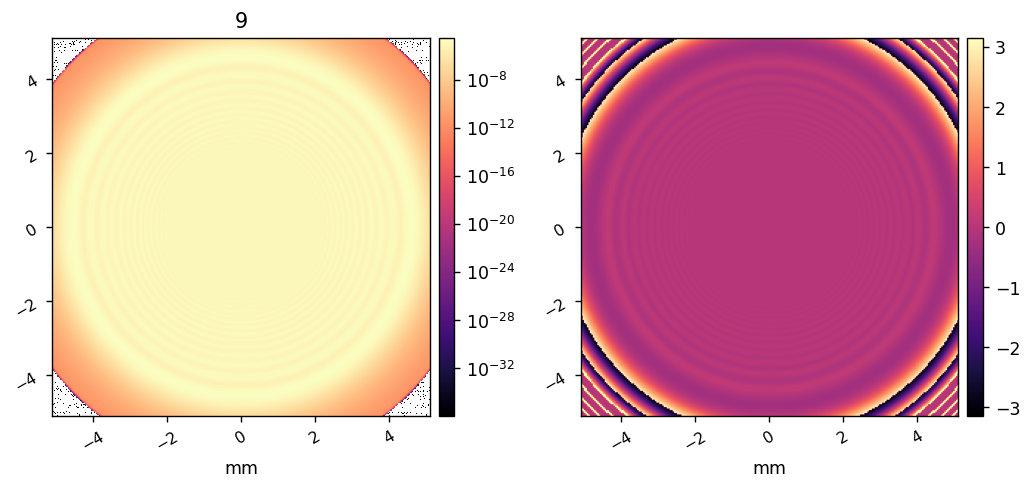

4.5954604798683026e-06 m / pix


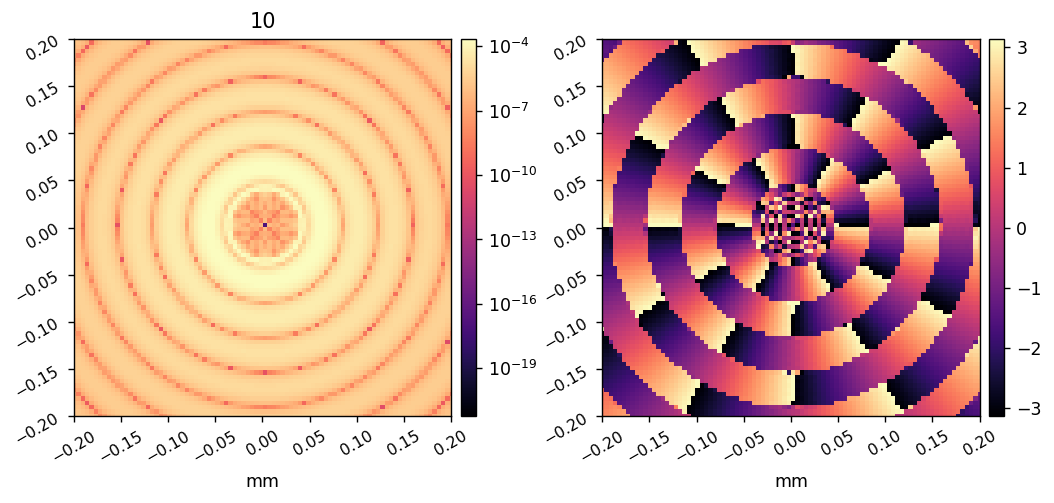

2.7892239511713292e-05 m / pix


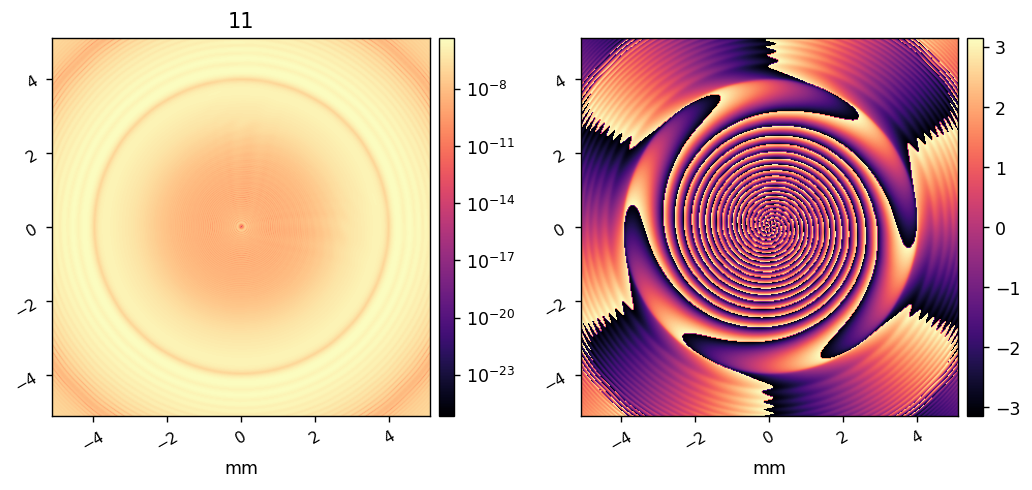

2.7892239511713292e-05 m / pix


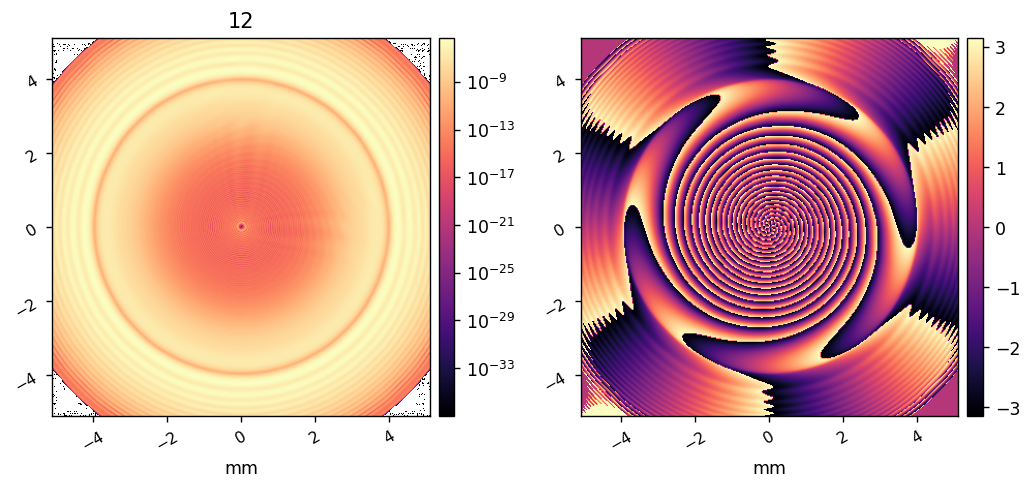

2.7892239511713292e-05 m / pix


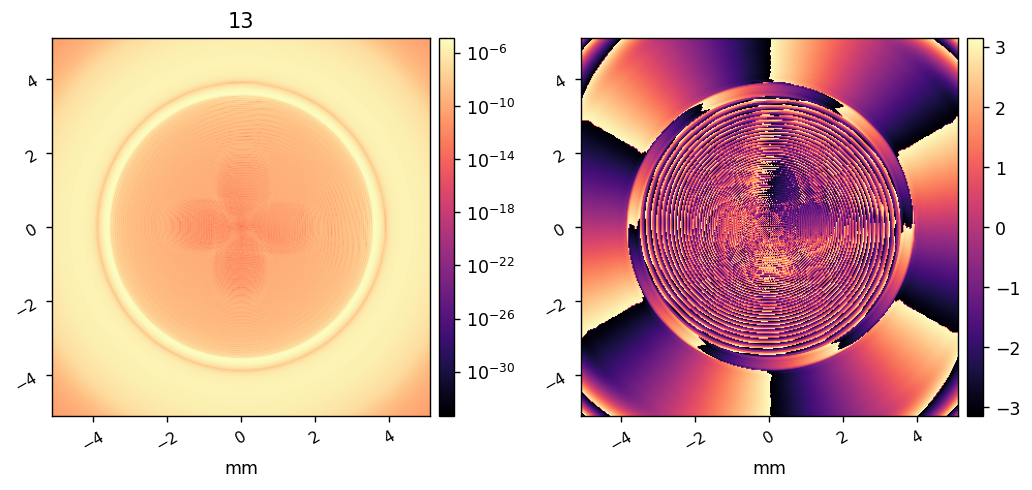

2.7892239511713292e-05 m / pix


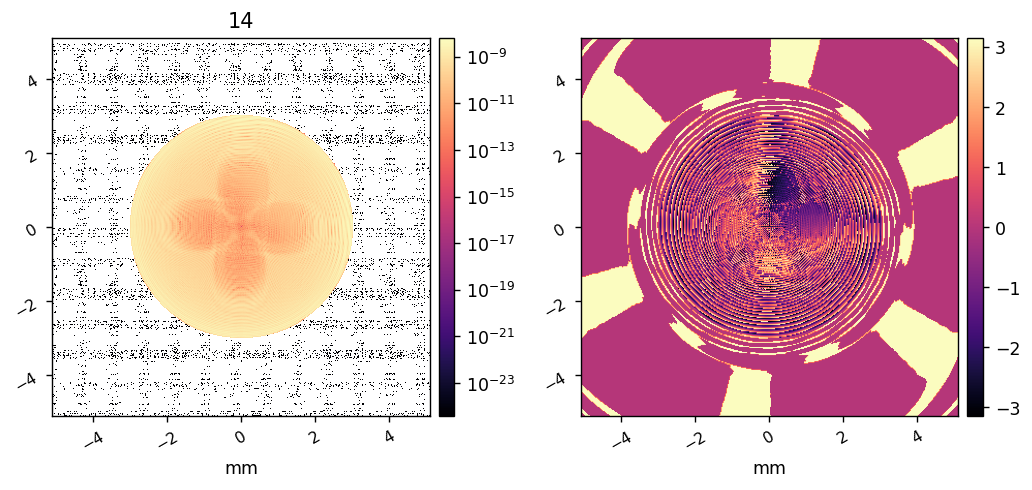

2.7892239511713292e-05 m / pix


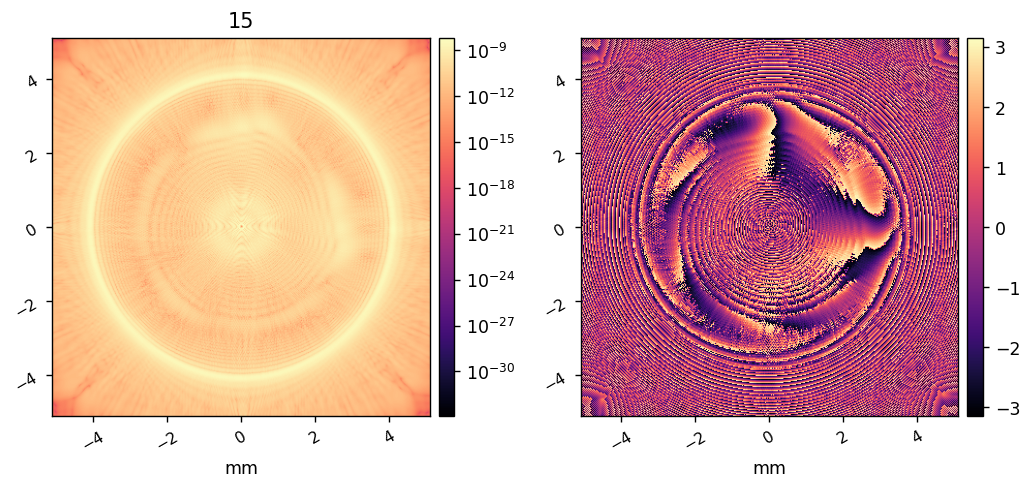

2.7892239511713292e-05 m / pix


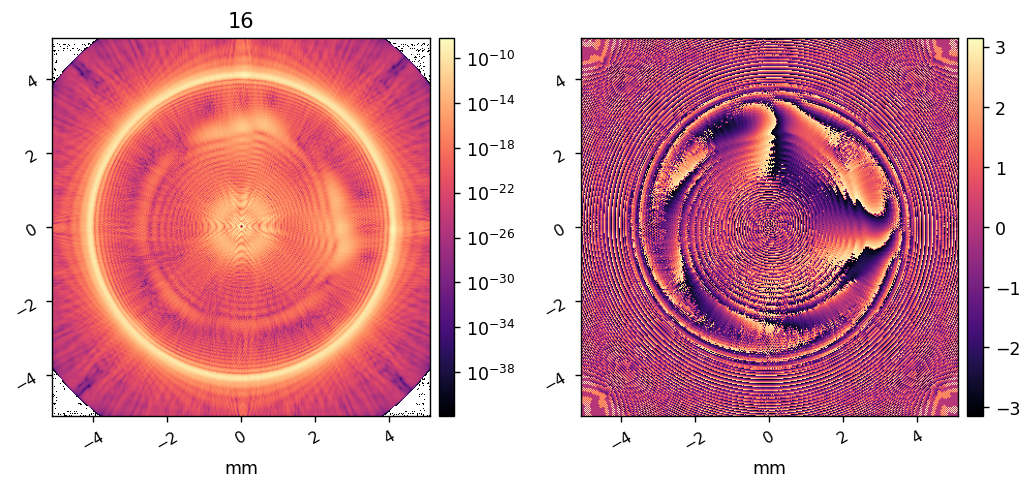

2.625861561223193e-06 m / pix


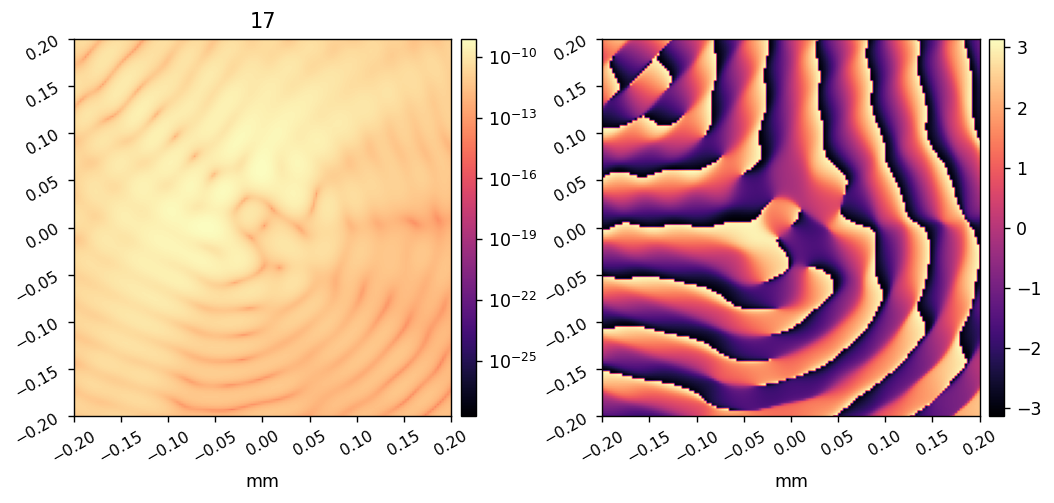

In [24]:
pupil_lim = c.pupil_diam.value/2
fp_lim = 1/5

for i,wf in enumerate(wfs):
    print(wf.pixelscale)
    if i in [c.inter_fp_index, c.fpm_index, c.image_index]:
        ext = [-fp_lim, fp_lim, -fp_lim, fp_lim]
    else:
        ext = [-pupil_lim, pupil_lim, -pupil_lim, pupil_lim]
    misc.imshow2(wf.intensity, wf.phase, '{:d}'.format(i), 
               pxscl1=wf.pixelscale.to(u.mm/u.pix), pxscl2=wf.pixelscale.to(u.mm/u.pix),
               axlims=ext,
               xlabel='mm',
               lognorm1=True)